<a href="https://colab.research.google.com/github/sanada5/Simulation-of-mathematical-models-of-decision-making/blob/main/Cube_model_with_two_alternatives_and_one_fall_back_option.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cube model with two alternatives and one fall-back option


In [ ]:
import numpy as np
import random
import math
from tabulate import tabulate
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



Wiener Process;

-Wiener(n, 2, T).T[0]- the first independent Wiener proces

-Wiener(n, 2, T). T[1]- the second independent Wiener process


In [ ]:
def Wiener(n, d, T):  #n- no of time steps, d-dimension of the Wiener process, T-the end time of simulation
    times=np.linspace(0, T, n)  #equally distanced n time steps
    dt=times[1]-times[0]
    dB=np.sqrt(dt)*np.random.normal(size=(n-1, d)) #dB=Wt2-Wt1 has normal distribution of mean 0 and var t2-t1=dt
    B0=np.zeros(shape=(1,d))    #Wiener process starts at 0
    B=np.concatenate((B0,np.cumsum(dB, axis=0)), axis=0) #to find the Wt1, add up all differences until Wt1-W(t1-dt)
    return B

In [ ]:
#initial preference of the decision maker towards each alternative is neutral i.e., x0=(0,0)
#(mu1, mu2) is the drift vector
#Sigma matrix is a diagonal matrix: ((s11, 0),(0, s22))
#time=ending time of the process
#N=number of simulations
def Cubemodel(time, N, n, d, mu1, mu2, s11, s22):
    times=np.linspace(0, time, n)   #timestep is time/n
    result={"Option1":0, "Option2":0, "Fall_back_option":0} #record of the number of times each of the options is chosen
    stopping_times=[]                       #the times determining the termination of the process
    episodes=np.zeros((2, N))  #record the time each episode of the process ends
    worst_best={"A1A2F":0, "A1FA2":0, "A2A1F":0, "A2FA1":0, "FA1A2":0, "FA2A1":0}  #possible ranking of the options according to the preference
    times_A1_favorite=[]
    times_A2_favorite=[]
    times_F_favorite=[]
    times_A1_least_favorite=[]
    times_A2_least_favorite=[]
    times_F_least_favorite=[]
    for i in range(N):
        #X(t)=(X1(t), X2(t))  #accumulation process
        #X1=mu1*t+s11*W1
        X1=np.ones(n)*mu1*times+s11*np.ones(n)*np.array(Wiener(n, d, time).T[0]) #vectorized values of X1 for each t in times
        #X2=mu2*t+s22*W2,
        X2=np.ones(n)*mu2*times+s22*np.ones(n)*np.array(Wiener(n, d, time).T[1])  #vectorized values of X2 for each t in times
        X1new=abs(X1)
        X2new=abs(X2)
        a=[k for k in X1new if k>=1]  #obtain those indices of values in X1 whose absolute value is >=1
        b=[k for k in X2new if k>=1]  #obtain those indices of values in X2 whose
        k1=list(X1new).index(a[0])    #take the first index of X1 sth in X1[k]>=1
        k2=list(X2new).index(b[0])
        k=min(k1,k2)  #one of the four boundaries is hit
        m1=X2[k]   #the value of X2 at the end of the first episode which is the initial value of X2 in the second episode
        m2=X1[k]    #the value of X1 at the end of the first episode
    #possible cases
        if m2>=1:   #the accept boundary of the first option is hit; the process ends, this option is chosen
            result["Option1"]+=1
            times_A1_favorite.append(times[k])
            stopping_times.append(times[k])
            episodes[0,i]=times[k]  #this process ends in one episode
            episodes[1, i]=0
            X2_sub=m1*np.ones(n)+np.ones(n)*mu2*times+s22*np.ones(n)*np.array(Wiener(n, 1, time).T[0])
            X2_sub1=abs(X2_sub)
            a_sub=[l for l in range(len(X2_sub1)) if X2_sub1[l]>=1]
            k_sub1=X2_sub[a_sub[0]]
            if k_sub1>=1:
                worst_best["A1A2F"]+=1
                times_F_least_favorite.append(times[k]+times[a_sub[0]])
            else:
                worst_best["A1FA2"]+=1
                times_A2_least_favorite.append(times[k]+times[a_sub[0]])
        elif m1>=1:   #the accept boundary of the second option is hit
            result["Option2"]+=1
            times_A2_favorite.append(times[k])
            stopping_times.append(times[k])
            episodes[0,i]=times[k]
            episodes[1, i]=0
            X1_sub=m2*np.ones(n)+np.ones(n)*mu1*times+s11*np.ones(n)*np.array(Wiener(n, 1, time).T[0]) #the process continues as one dimensional Wiener process with drift
            X1_sub1=abs(X1_sub)
            b_sub=[k for k in range(len(X1_sub1)) if X1_sub1[k]>=1]
            k_sub2=X1_sub[b_sub[0]]
            if k_sub2>=1:
                worst_best["A2A1F"]+=1
                times_F_least_favorite.append(times[k]+times[b_sub[0]])
            else:
                worst_best["A2FA1"]+=1
                times_A1_least_favorite.append(times[k]+times[b_sub[0]])
        elif m2<=-1:      #the reject boundary of the first option is hit, the process acts as a 1-d Wiener process with drift
            times_A1_least_favorite.append(times[k])
            episodes[0, i]=times[k]  #the process follows two episodes
            X2_1=m1*np.ones(n)+np.ones(n)*mu2*times+s22*np.ones(n)*np.array(Wiener(n, 1, time).T[0])
            X2new1=abs(X2_1)
            a=[k for k in X2new1 if k>=1]
            k11=list(X2new1).index(a[0])  #first element in X2 whose absolute value is >=1
            if X2_1[k11]>=1:  #the accept boundary of the second option is hit; option 2 is chosen
                result["Option2"]+=1
                stopping_times.append(times[k]+times[k11])
                episodes[1, i]=times[k11]
                worst_best["A2FA1"]+=1
                times_A2_favorite.append(times[k]+times[k11])
            else:   #the reject boundary of the second option is hit
                result["Fall_back_option"]+=1
                stopping_times.append(times[k]+times[k11])   #one is left with the Fall back option
                episodes[1, i]=times[k11]
                worst_best["FA2A1"]+=1
                times_F_favorite.append(times[k]+times[k11])
        else:   #X2[k]<=-1, i.e. the reject boundary of the second option is hit
            times_A2_least_favorite.append(times[k])
            episodes[0, i]=times[k]
            X1=m2*np.ones(n)+np.ones(n)*mu1*times+s11*np.ones(n)*np.array(Wiener(n, 1, time).T[0]) #the process continues as one dimensional Wiener process with drift
            X1new=abs(X1)
            b=[k for k in X1new if k>=1]
            k22=list(X1new).index(b[0])
            if X1[k22]>=1:  #the accept boundary of the first option is hit
                result["Option1"]+=1  #the first option is chosen
                stopping_times.append(times[k]+times[k22])
                episodes[1, i]=times[k22]
                worst_best["A1FA2"]+=1
                times_A1_favorite.append(times[k]+times[k22])
            else:  #otherwise X1[k22]<=-1 thus the reject boundary of option 1 is hit and one is left with the fall back option
                result["Fall_back_option"]+=1
                stopping_times.append(times[k]+times[k22])
                episodes[1, i]=times[k22]
                worst_best["FA1A2"]+=1
                times_F_favorite.append(times[k]+times[k22])
    data=[[worst_best["A1A2F"]/N, worst_best["A1FA2"]/N,worst_best["A2A1F"]/N, worst_best["A2FA1"]/N,worst_best["FA1A2"]/N, worst_best["FA2A1"]/N],[np.mean(times_A1_favorite), np.mean(times_A2_favorite), np.mean(times_F_favorite)],[np.mean(times_A1_least_favorite), np.mean(times_A2_least_favorite), np.mean(times_F_least_favorite)]]
    return "The choice probabilities for option 1, option 2, and fall-back option are {}, {}, and {} respectively. The mean of the reaction time is {}.".format(result["Option1"]/N, result["Option2"]/N, result["Fall_back_option"]/N, np.mean((stopping_times))), stopping_times, data, episodes, "The average durations of the first and second episode of the process are {} and {} respectively".format(np.mean(episodes[0]), np.mean(episodes[1]))


In [ ]:
summary, reaction_time, worst_best, episodes, info_episodes=Cubemodel(100, 3000,20000, 2, 0, 0, 1, 1)  #take (mu1, mu2, s11, s22)=(0,0,1,1)

Find the choice probability for each option and the mean of the reaction time:

In [ ]:
summary

'The choice probabilities for option 1, option 2, and fall-back option are 0.387, 0.37166666666666665, and 0.24133333333333334 respectively. The mean of the reaction time is 1.066289981165725.'

Display the probability distribution of the reaction time random variable (the vertical line is the mean of it):

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


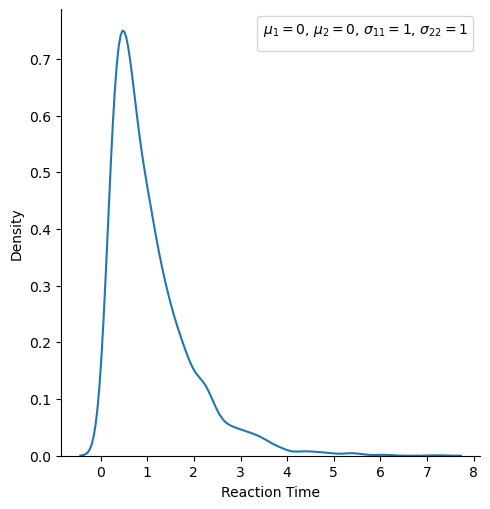

In [ ]:
sns.displot(data=reaction_time,kind='kde')
plt.xlabel('Reaction Time')
plt.ylabel('Density')
plt.legend(title=r"$\mu_{1}=0$, $\mu_{2}=0$, $\sigma_{11}=1$, $\sigma_{22}=1$")
plt.show()

Find the choice probabilities of each of worst-best scenarios and of the possibilities describing each of the options as being the most/least preferred. Find the corresponding mean time:

In [ ]:
head1=["P[A1A2F]".translate(SUB), "P[A1FA2]".translate(SUB), "P[A2A1F]".translate(SUB), "P[A2FA1]".translate(SUB), "P[FA1A2]".translate(SUB), "P[FA2A1]".translate(SUB)]
mydata1=[worst_best[0]] #the probabilities of each of the worst_best scenarios
df1=pd.DataFrame(mydata1,columns=head1)
df1

,P[A₁A₂F],P[A₁FA₂],P[A₂A₁F],P[A₂FA₁],P[FA₁A₂],P[FA₂A₁]
0,0.134,0.253,0.129,0.242667,0.108,0.133333


In [ ]:
head2=["P[A1 is the most preferred option]".translate(SUB), "P[A2 is the most preferred option]".translate(SUB), "P[F is the most preferred option]".translate(SUB)]
mydata2=[[worst_best[0][0]+worst_best[0][1],worst_best[0][2]+worst_best[0][3], worst_best[0][4]+worst_best[0][5]]] #the probabilities for the scenarios where options A1, A2, F are the most preferred ones
df2=pd.DataFrame(mydata2, columns=head2)
df2

,P[A₁ is the most preferred option],P[A₂ is the most preferred option],P[F is the most preferred option]
0,0.387,0.371667,0.241333


In [ ]:
head3=["P[A1 is the least preferred option]".translate(SUB), "P[A2 is the least preferred option]".translate(SUB), "P[F is the least preferred option]".translate(SUB)]
mydata3=[[worst_best[0][3]+worst_best[0][5],worst_best[0][1]+worst_best[0][4],worst_best[0][2]+worst_best[0][0]]]  #the probabilities for the scenarios where options A1, A2, F are the most preferred ones
df3=pd.DataFrame(mydata3, columns=head3)
df3

,P[A₁ is the least preferred option],P[A₂ is the least preferred option],P[F is the least preferred option]
0,0.376,0.361,0.263


In [ ]:
head4=["A1 most preferred / mean time".translate(SUB),"A2 most preferred / mean time".translate(SUB),"F most preferred / mean time".translate(SUB)]
mydata4=[worst_best[1]]  #the mean of the times determining the choice of options A1, A2, F as the most preferred one respectively
df4=pd.DataFrame(mydata4, columns=head4)
df4

,A₁ most preferred / mean time,A₂ most preferred / mean time,F most preferred / mean time
0,0.885527,0.96112,1.518128


In [ ]:
head5=["A1 least preferred / mean time".translate(SUB),"A2 least preferred / mean time".translate(SUB),"F least preferred / mean time".translate(SUB)]  #the mean of the times determining the choice of options A1, A2, F as the most preferred one respectively
mydata5=[worst_best[2]]
df5=pd.DataFrame(mydata5, columns=head5)
df5

,A₁ least preferred / mean time,A₂ least preferred / mean time,F least preferred / mean time
0,0.959334,0.91927,1.540685


Find the mean of the stopping times in each episode:

In [ ]:
info_episodes

'The average durations of the first and second episode of the process are 0.6442205443605513 and 0.42206943680517356 respectively'

Obtain the distribution of stopping times of each episode

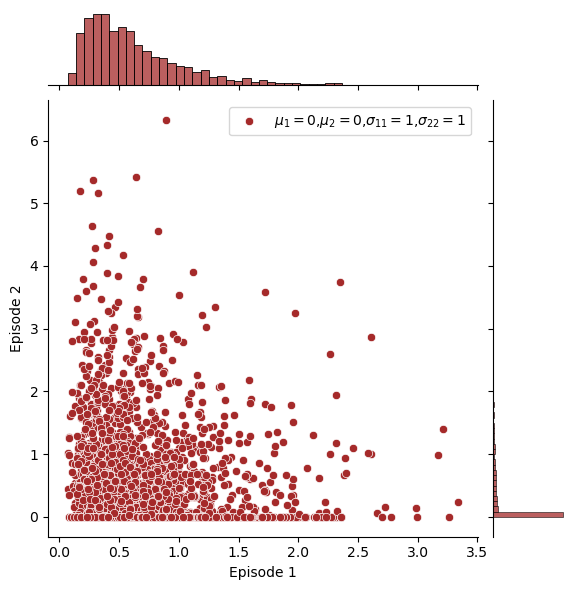

In [ ]:
episodes_new=pd.DataFrame({"Episode 1": episodes[0], "Episode 2": episodes[1]})
sns.jointplot(x="Episode 1",y="Episode 2", data=episodes_new, color="brown", label=r"$\mu_{1}=0$,$\mu_{2}=0$,$\sigma_{11}=1$,$\sigma_{22}=1$")
plt.legend()
#plt.savefig("Joint6.png")